# Experiment 3a: Steering at Thought Anchors (KL vs. beta)

This notebook loads:
- an annotated example with a thought anchor,
- the corresponding steering vector computed in `experiments/find_steering_vectors.py`,

and measures how the next-token distribution changes when we steer activations
at the layer and position just before the anchor sentence. We sweep steering amplitude
`beta` in [-1, 1] and compute KL divergence vs. the unsteered baseline.

In [1]:
import os, json, math
from typing import List, Dict

import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))
from utils import load_model_and_vectors, split_solution_into_chunks

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/opt/conda/envs/anchorsteering/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
# Config
model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B'
model_tag = model_name.replace('/', '-')
from pathlib import Path
# Find repo root by searching upwards for 'generated_data' (fallback: cwd)
cwd = Path.cwd()
repo_root = next((p for p in [cwd] + list(cwd.parents) if (p / 'generated_data').exists()), cwd)
# Build absolute paths to the generated_data files
annotated_path = repo_root / 'generated_data' / f'generated_data_annotated_{model_tag}.json'
vectors_path = repo_root / 'generated_data' / f'steering_vectors_{model_tag}.json'
example_index = 0  # change to pick a different example

# Steering amplitudes to test
betas = np.linspace(-0.1, 0.1, 9)  # [-1, ..., 1]
betas

array([-0.1  , -0.075, -0.05 , -0.025,  0.   ,  0.025,  0.05 ,  0.075,
        0.1  ])

In [3]:
# Load model/tokenizer
model, tokenizer, _ = load_model_and_vectors(model_name=model_name, compute_features=False, device=device)
model.model.eval()

# Load data
with open(annotated_path, 'r') as f:
    annotated = json.load(f)
with open(anchors_path, 'r') as f:
    anchors_payload = json.load(f)
len(annotated), len(anchors_payload.get('examples', []))


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


No mean vectors found for deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B. You can save to generated_data/mean_vectors_deepseek-r1-distill-qwen-1.5b.pt.


FileNotFoundError: [Errno 2] No such file or directory: '/home/cutterdawes/SteeringThoughtAnchors/notebooks/generated_data/generated_data_annotated_deepseek-ai-DeepSeek-R1-Distill-Qwen-1.5B.json'

In [ ]:
# Select example and load per-chunk steering vectors
ex = None
if example_index < len(annotated):
    ex = annotated[example_index]
else:
    ex = annotated[0]

question = ex['prompt']
cot = ex['cot']
anchor_idx = ex.get('thought_anchor_idx', None)
anchor_sentence = ex.get('thought_anchor_sentence', '')

# Load chunk vectors for the matching example from anchors payload
examples_anchors = anchors_payload.get('examples', [])
vi = min(example_index, len(examples_anchors)-1) if examples_anchors else 0
anchors_ex = examples_anchors[vi] if examples_anchors else {}
layer_idx = anchors_ex.get('layer', model.config.num_hidden_layers - 1)

# Build a mapping: chunk_index -> vector tensor
chunk_vectors = {}
for ch in anchors_ex.get('chunks', []):
    vec = torch.tensor(ch.get('vector', []), dtype=(torch.bfloat16 if model.model.dtype==torch.bfloat16 else torch.float32), device=device)
    chunk_vectors[int(ch.get('chunk_index', 0))] = vec

# Default steer_vector: use the anchor's chunk vector if present, else chunk 0
steer_vector = chunk_vectors.get(int(anchor_idx) if anchor_idx is not None else 0, next(iter(chunk_vectors.values()), torch.zeros(model.config.hidden_size, dtype=torch.float32, device=device)))
len(chunk_vectors), layer_idx, anchor_idx, anchor_sentence[:80] + ('...' if len(anchor_sentence)>80 else '')


(1536, 27, 13, 'Okay, so that gives me 240.')

In [ ]:
# Build the prefix up to (but not including) the anchor sentence
chunks = split_solution_into_chunks(cot)
if anchor_idx is None or anchor_idx < 0 or anchor_idx >= len(chunks):
    # fallback: find sentence match
    try:
        anchor_idx = next((i for i,s in enumerate(chunks) if s.strip()==anchor_sentence.strip()), 0)
    except Exception:
        anchor_idx = 0
prefix_text = '\n'.join(chunks[:anchor_idx])

prompt = (
    "Solve the following problem step by step. You MUST put your final answer in \\boxed{}.\n\n"
    f"Problem: {question}\n\n"
    f"Solution:\n<think>\n{prefix_text}"
)
ids = tokenizer(prompt, return_tensors='pt')
input_ids = ids['input_ids'].to(device)
pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else (tokenizer.eos_token_id or 0)
attention_mask = (input_ids != pad_id).long().to(device)
input_ids.shape, attention_mask.shape, input_ids[0, -5:]

(torch.Size([1, 342]),
 torch.Size([1, 342]),
 tensor([220,  17,  19,  15,  13], device='cuda:0'))

In [ ]:
@torch.no_grad()
def _forward_with_logits(input_ids, attention_mask):
    # Try to get logits; if the called path returns only hidden states, project via lm_head
    outputs = model.model(input_ids=input_ids, attention_mask=attention_mask, use_cache=False, output_hidden_states=True, return_dict=True)
    logits = getattr(outputs, 'logits', None)
    if logits is None:
        last_hidden = outputs.last_hidden_state if hasattr(outputs, 'last_hidden_state') else outputs[0]
        # Resolve the lm_head either on the top-level or on the causal LM module
        head_owner = model if hasattr(model, 'lm_head') else (model.model if hasattr(model.model, 'lm_head') else None)
        if head_owner is None:
            raise AttributeError('Could not find lm_head on model or model.model')
        logits = head_owner.lm_head(last_hidden)
    return logits

In [ ]:
# Measurement mode toggle
teacher_forced_mode = True  # compare logits at same positions (teacher-forced)


In [ ]:
# Generalized helpers to steer arbitrary chunk prefixes (RMS-scaled beta, per-chunk vectors)
@torch.no_grad()
def logits_with_steer_for(prefix_ids: torch.Tensor, attn_mask: torch.Tensor, beta: float):
    # Apply steering at target layer for the last position of prefix_ids, scaling by RMS
    backbone = getattr(model.model, 'model', model.model)
    target = backbone.layers[layer_idx]
    # Use global steer_vector set for current chunk
    d = steer_vector.detach().to(torch.float32)
    d = d / (d.norm() + 1e-12)
    def hook(module, inputs, output):
        out = output
        try:
            if isinstance(out, tuple):
                h = out[0].clone()
                rest = out[1:]
            else:
                h = out.clone()
                rest = tuple()
            h_last_fp32 = h[:, -1:, :].to(torch.float32)
            rms = torch.sqrt(torch.mean(h_last_fp32 ** 2) + 1e-20)
            delta_fp32 = (float(beta) * rms) * d.view(1, 1, -1)
            h[:, -1:, :] = (h_last_fp32 + delta_fp32).to(h.dtype)
            return (h,) + rest if isinstance(out, tuple) else h
        except Exception:
            return output
    handle = target.register_forward_hook(hook)
    try:
        logits = _forward_with_logits(prefix_ids, attn_mask)
        return logits[:, -1, :]
    finally:
        handle.remove()

@torch.no_grad()
def kl_curve_for_chunk(chunk_idx: int, betas: np.ndarray):
    """
    For the given chunk index, compare base distributions with steered ones.
    If teacher_forced_mode is True, both base and steered logits are computed on the same token positions (teacher-forced).
    Otherwise, run a free-running rollout. Uses the chunk's own steering vector.
    """
    global steer_vector
    # Set the steer_vector for this chunk (default to chunk 0 if missing)
    if chunk_idx in chunk_vectors:
        steer_vector = chunk_vectors[chunk_idx]
    else:
        if 0 in chunk_vectors:
            steer_vector = chunk_vectors[0]
        else:
            # No vectors available; return zeros
            return [0.0 for _ in betas]

    # Build prefix up to the chunk and get the exact chunk tokens
    prefix_text = '
'.join(chunks[:chunk_idx])
    chunk_text = chunks[chunk_idx]
    chunk_ids = tokenizer(chunk_text, return_tensors='pt', add_special_tokens=False)['input_ids']  # [1, T]
    n_steps = int(chunk_ids.shape[-1])

    prompt_prefix = (
        "Solve the following problem step by step. You MUST put your final answer in \boxed{}.\n\n"
        f"Problem: {question}\n\n"
        "Solution:
<think>
"
        f"{prefix_text}"
    )
    # Encode prefix and full (prefix + original chunk text) to align base logits via a single forward
    enc_prefix = tokenizer(prompt_prefix, return_tensors='pt')
    ids_pref = enc_prefix['input_ids'].to(device)
    pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else (tokenizer.eos_token_id or 0)
    am_pref = (ids_pref != pad_id).long().to(device)

    full_text = prompt_prefix + chunk_text
    enc_full = tokenizer(full_text, return_tensors='pt')
    ids_full = enc_full['input_ids'].to(device)
    am_full = (ids_full != pad_id).long().to(device)

    # Align chunk within full sequence
    full_ids = ids_full[0].tolist()
    chunk_seq = tokenizer(chunk_text, return_tensors='pt', add_special_tokens=False)['input_ids'][0].tolist()
    s_idx = -1
    for pos in range(max(0, ids_pref.shape[-1]-4), len(full_ids)-len(chunk_seq)+1):
        if full_ids[pos:pos+len(chunk_seq)] == chunk_seq:
            s_idx = pos
            break
    if s_idx == -1:
        s_idx = int(ids_pref.shape[-1])
    # start index points to position that predicts first chunk token (the previous position)
    start = max(0, s_idx - 1)
    logits_full = _forward_with_logits(ids_full, am_full)  # [1, L, V]
    seq_len = int(logits_full.shape[1])
    n_eff = max(0, min(n_steps, seq_len - start))
    base_steps = logits_full[:, start:start + n_eff, :]
    base_avg = base_steps.mean(dim=1)  # [1,V]

    def kl_from_logits(avg_logits_p, avg_logits_q):
        logp = torch.log_softmax(avg_logits_p, dim=-1)
        logq = torch.log_softmax(avg_logits_q, dim=-1)
        p = torch.exp(logp)
        return torch.sum(p * (logp - logq), dim=-1)

    curve = []

    if teacher_forced_mode:
        # Same-position comparison: steer at the token just before the chunk (start)
        for b in betas:
            if abs(b) < 1e-12:
                curve.append(0.0)
                continue
            steered_logits = logits_with_steer_full(ids_full, am_full, float(b), start)
            steered_span = steered_logits[:, start:start + n_eff, :]
            base_span = logits_full[:, start:start + n_eff, :]
            # Average KL across the span positions
            kl_t = kl_from_logits(steered_span.reshape(-1, steered_span.shape[-1]), base_span.reshape(-1, base_span.shape[-1]))
            curve.append(float(kl_t.mean().item()))
        return curve

    # Free-running rollout
    for b in betas:
        if abs(b) < 1e-12:
            curve.append(0.0)
            continue
        logs = []
        pf = ids_pref.clone(); amf = am_pref.clone()
        for k in range(n_steps):
            l = logits_with_steer_for(pf, amf, float(b))
            logs.append(l.detach().to(torch.float32))
            next_id = torch.argmax(l, dim=-1)
            pf = torch.cat([pf, next_id.unsqueeze(0)], dim=1)
            amf = torch.cat([amf, torch.ones_like(next_id).unsqueeze(0)], dim=1)
        steered_avg = torch.stack(logs, dim=0).mean(dim=0)
        kl = kl_from_logits(steered_avg, base_avg)
        curve.append(float(kl.item()))
    return curve

@torch.no_grad()
def logits_with_steer_full(input_ids: torch.Tensor, attention_mask: torch.Tensor, beta: float, target_pos: int):
    """Run a full forward pass with a steering delta applied at a specific token index in the chosen layer.
    The perturbation is applied at the token that predicts the next token at target_pos+1. Scales by RMS.
    """
    backbone = getattr(model.model, 'model', model.model)
    target = backbone.layers[layer_idx]
    d = steer_vector.detach().to(torch.float32)
    d = d / (d.norm() + 1e-12)
    def hook(module, inputs, output):
        out = output
        try:
            if isinstance(out, tuple):
                h = out[0].clone(); rest = out[1:]
            else:
                h = out.clone(); rest = tuple()
            pos = int(target_pos)
            if pos < 0 or pos >= h.shape[1]:
                return output
            h_slice_fp32 = h[:, pos:pos+1, :].to(torch.float32)
            rms = torch.sqrt(torch.mean(h_slice_fp32 ** 2) + 1e-20)
            delta_fp32 = (float(beta) * rms) * d.view(1, 1, -1)
            h[:, pos:pos+1, :] = (h_slice_fp32 + delta_fp32).to(h.dtype)
            return (h,) + rest if isinstance(out, tuple) else h
        except Exception:
            return output
    handle = target.register_forward_hook(hook)
    try:
        return _forward_with_logits(input_ids, attention_mask)
    finally:
        handle.remove()


In [ ]:
# Compute KL for the anchor using the exact same implementation as the per-chunk routine
# This calls kl_curve_for_chunk which conditions the base logits on the ground-truth chunk
# and performs the identical free-running steered rollout used for other chunks.
kl_values = kl_curve_for_chunk(anchor_idx, betas)
kl_values

[1.2672427892684937,
 1.2672600746154785,
 1.2670834064483643,
 1.2671250104904175,
 0.0,
 1.2672336101531982,
 1.2672014236450195,
 1.2672280073165894,
 1.2672488689422607]

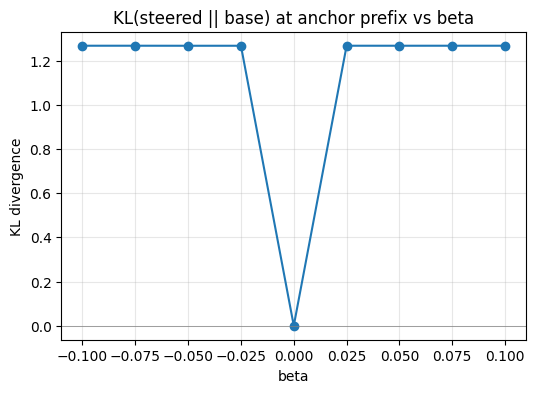

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(betas, kl_values, marker='o')
plt.axhline(0, color='gray', lw=0.5)
plt.title('KL(steered || base) at anchor prefix vs beta')
plt.xlabel('beta (× RMS)')
plt.ylabel('KL divergence')
plt.grid(True, alpha=0.3)
plt.show()


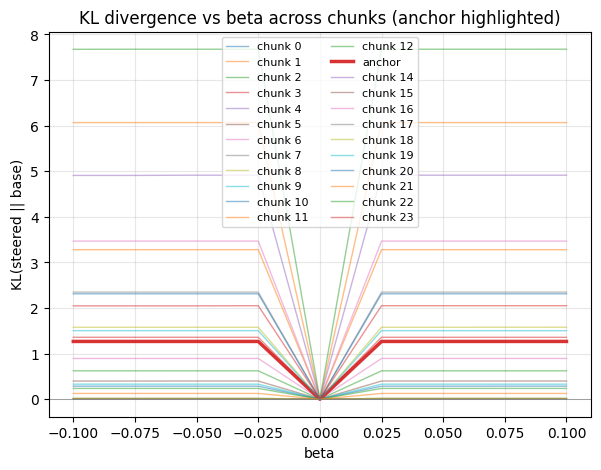

In [ ]:
# Compute KL curves for all chunks (cap to at most 12 for readability) and plot
kl_curves = {}
for idx in range(len(chunks)):
    kl_curves[idx] = kl_curve_for_chunk(idx, betas)

plt.figure(figsize=(7,5))
for idx, vals in kl_curves.items():
    ls = '-'
    lw = 2.5 if idx == anchor_idx else 1.0
    alpha = 0.95 if idx == anchor_idx else 0.5
    label = 'anchor' if idx == anchor_idx else f'chunk {idx}'
    plt.plot(betas, vals, ls, linewidth=lw, alpha=alpha, label=label)
plt.axhline(0, color='gray', lw=0.5)
plt.xlabel('beta (× RMS)'); plt.ylabel('KL(steered || base)')
plt.title('KL divergence vs beta across chunks (anchor highlighted)')
plt.legend(ncol=2, fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# print chunk importances for reference
[(counterfac_importance, chunk) for (counterfac_importance, chunk) in zip(ex['counterfactual_importance_kl'], chunks)]

[(0.8109300378873879,
  'Okay, so I have this problem to solve: evaluate the product of four cube roots multiplied together.'),
 (0.0040324184185464435,
  "It's written as √[3]{12} × √[3]{20} × √[3]{15} × √[3]{60}."),
 (0.6061356272480818,
  'Hmm, cube roots can sometimes be tricky, but I remember that when you multiply cube roots, you can combine them under a single cube root.'),
 (0.0, 'Let me try to recall the properties of radicals.'),
 (0.0, 'I think the rule is that √[n]{a} × √[n]{b} = √[n]{a × b}.'),
 (0.318453559904557,
  'So, in this case, since all of them are cube roots, I can multiply all the numbers inside the roots together and then take the cube root of the product.'),
 (0.7884571822188209, 'That should simplify things a lot.'),
 (0.0, 'Let me write that down:'),
 (0.0, '√[3]{12} × √[3]{20} × √[3]{15} × √[3]{60} = √[3]{12 × 20 × 15 × 60}'),
 (0.046260159866807676,
  'Alright, so now I just need to compute the product inside the cube root.'),
 (0.356674771771653, "Let's c

In [ ]:
for i in range(len(chunks)):
    print(f'{i}: KL {max(kl_curves[i]):.2f}. {chunks[i]}')

NameError: name 'kl_curves' is not defined